In [2]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Saving kaggle.json to kaggle (1).json
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from zipfile import ZipFile
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
os.chdir('/content/yes')
X = []
y = []
for i in tqdm(os.listdir()):
      img = cv2.imread(i)   
      img = cv2.resize(img,(256,256))
      X.append(img)
      y.append((i[0:1]))
os.chdir('/content/no')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)   
      img = cv2.resize(img,(256,256))
      X.append(img)
for i in range(1,99):
    y.append('N')

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

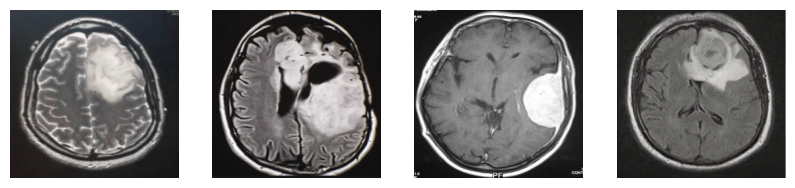

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (256, 256, 3)
Shape of an image in X_test:  (256, 256, 3)


In [8]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [9]:
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape) 
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (202, 256, 256, 3)
X_test Shape:  (51, 256, 256, 3)
y_train Shape:  (202, 2)
y_test Shape:  (51, 2)


In [10]:
import tensorflow as tf
import numpy as np
from collections import deque
import random
from prettytable import PrettyTable

class DQNAgent:
    def __init__(self, state_shape, action_size, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.01):
        self.state_shape = state_shape
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=100000)
        self.model = self._build_model()
        self.state_size = 202

    def _build_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (5,5), activation='relu', padding = 'same', input_shape=self.state_shape),
            tf.keras.layers.MaxPool2D(2,2),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D(2,2),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='sigmoid')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy')
        return model

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            # Choose a random action
            action = np.random.choice(self.action_size)
        else:
            # Choose the action with the highest Q-value
            q_values = self.model.predict(state.reshape(1, *self.state_shape))
            action = np.argmax(q_values)
        return action

    def update_replay_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states = []
        targets = []
        for state, action, reward, next_state, done in minibatch:
            states.append(state)
            q_values = self.model.predict(state.reshape(1, *self.state_shape))[0]
            if done:
                q_values[action] = reward
            else:
                next_q_values = self.model.predict(next_state.reshape(1, *self.state_shape))[0]
                q_values[action] = reward + self.gamma * np.max(next_q_values)
            targets.append(q_values)
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=2)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    #def predict(self, state):
        #state = state.reshape(1, *self.state_shape)
       # action_probabilities = self.model.predict(state)
        #predicted_action = 1 if action_probabilities > 0.5 else 0
       # return predicted_action

    def predict(self,state):
        state = state.reshape(1, *self.state_shape)
        action_probabilities = self.model.predict(state)
        action = np.argmax(action_probabilities)
        return action
    
    def get_q_table(self, states):
        q_table = []
        for state in range(len(states)):
            state_values = []
            for action in range(self.action_size):
                q_values = self.model.predict(np.array([states[X_train]]))[0]
                policy = np.argmax(q_values)
                value = np.max(q_values)
                state_values.append([state, action, policy, value])
            q_table.extend(state_values)
        return q_table


    def get_accuracy(self, X, y):
        total_predictions = len(X)
        correct_predictions = 0
        for i in range(total_predictions):
            state = X[i]
            action = y[i][0] # Select the first element of the array
            predicted_action = self.get_action(state) # No need to select the first element
            if action == predicted_action:
                correct_predictions += 1
        accuracy = 100 * correct_predictions / total_predictions
        #print(f"Correct Prediction: {correct_predictions} over Total Predictions:{total_predictions}")
        return accuracy

    def get_loss(self, X, y):
        total_predictions = len(X)
        wrong_predictions = 0
        for i in range(total_predictions):
            state = X[i]
            action = y[i][0] # Select the first element of the array
            predicted_action = self.get_action(state) # No need to select the first element
            if action != predicted_action:
                wrong_predictions += 1
        loss = 100 * wrong_predictions / total_predictions
        #print(f"Correct Prediction: {correct_predictions} over Total Predictions:{total_predictions}")
        return loss
        



In [192]:
import numpy as np

# Create an instance of the DQNAgent class
state_shape = (256, 256, 3)
action_size = 2
agent = DQNAgent(state_shape, action_size)

# Generate a random state and get an action from the agent
state = np.random.rand(*state_shape)
action = agent.get_action(state)

# Update the agent's replay memory with a transition
reward = 0.5
next_state = np.random.rand(*state_shape)
done = False
agent.update_replay_memory(state, action, reward, next_state, done)

#to run multiple times 
max_accuracy = 0.0
num_runs = 10000
accuracy_list = []

# Train the agent on a batch of transitions
agent.train(256)

for i in range(num_runs):
     accuracy = agent.get_accuracy(X_train, y_train)
     if accuracy > max_accuracy:
        max_accuracy = accuracy
     accuracy_list.append(max_accuracy)
print("Accuracy:", max_accuracy)

Accuracy: 65.34653465346534


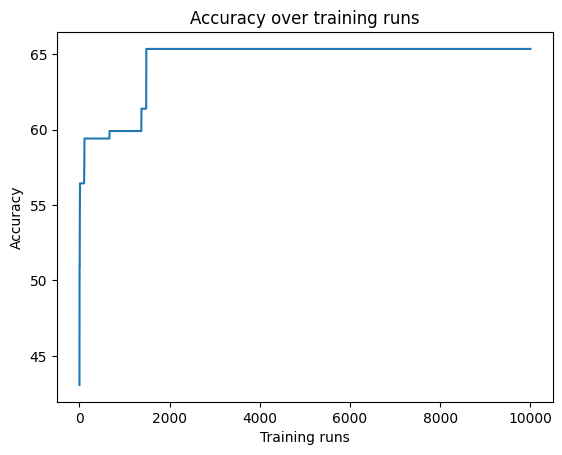

In [193]:
import matplotlib.pyplot as plt

plt.plot(accuracy_list)
plt.title('Accuracy over training runs')
plt.xlabel('Training runs')
plt.ylabel('Accuracy')

plt.show()

In [194]:
import numpy as np

# Create an instance of the DQNAgent class
state_shape = (256, 256, 3)
action_size = 2
agent = DQNAgent(state_shape, action_size)

# Generate a random state and get an action from the agent
state = np.random.rand(*state_shape)
action = agent.get_action(state)

# Update the agent's replay memory with a transition
reward = 0.5
next_state = np.random.rand(*state_shape)
done = False
agent.update_replay_memory(state, action, reward, next_state, done)

# Train the agent on a batch of transitions
agent.train(256)
#for multiple times
max_val_accuracy = 0.0
num_runs = 10000
val_accuracy_list = []

# Get the accuracy of the agent on a train set
for i in range(num_runs):
       val_accuracy = agent.get_accuracy(X_test, y_test)
       if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
       val_accuracy_list.append(max_val_accuracy)
print(" Validation Accuracy:", max_val_accuracy)

 Validation Accuracy: 84.31372549019608


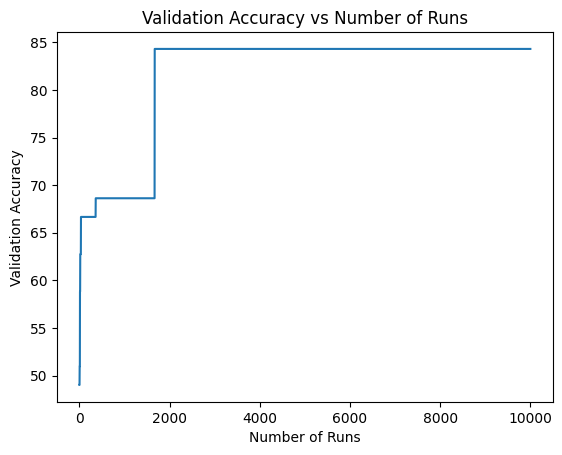

In [195]:
import matplotlib.pyplot as plt

plt.plot(val_accuracy_list)
plt.xlabel('Number of Runs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Number of Runs')
plt.show()

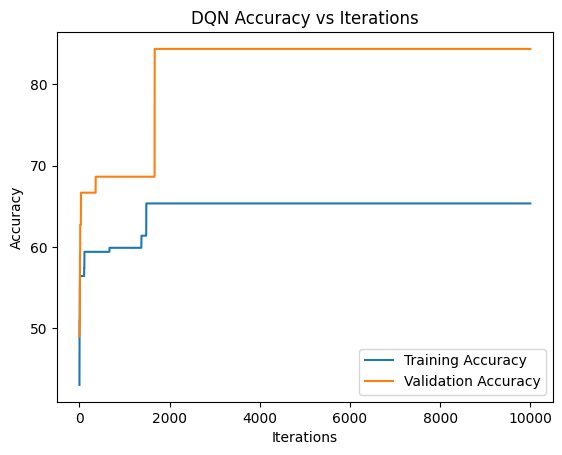

In [199]:
# plot the accuracy vs iterations
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('DQN Accuracy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [200]:
import numpy as np

# Create an instance of the DQNAgent class
state_shape = (256, 256, 3)
action_size = 2
agent = DQNAgent(state_shape, action_size)

# Generate a random state and get an action from the agent
state = np.random.rand(*state_shape)
action = agent.get_action(state)

# Update the agent's replay memory with a transition
reward = 0.5
next_state = np.random.rand(*state_shape)
done = False
agent.update_replay_memory(state, action, reward, next_state, done)

#to run multiple times 
min_loss = 100.0
num_runs = 10000
loss_list = []

# Train the agent on a batch of transitions
agent.train(256)

for i in range(num_runs):
     loss = agent.get_loss(X_train, y_train)
     if  loss < min_loss:
        min_loss = loss
     loss_list.append(min_loss)
print("DQN Loss:", min_loss)

DQN Loss: 37.12871287128713


In [201]:
import numpy as np

# Create an instance of the DQNAgent class
state_shape = (256, 256, 3)
action_size = 2
agent = DQNAgent(state_shape, action_size)

# Generate a random state and get an action from the agent
state = np.random.rand(*state_shape)
action = agent.get_action(state)

# Update the agent's replay memory with a transition
reward = 0.5
next_state = np.random.rand(*state_shape)
done = False
agent.update_replay_memory(state, action, reward, next_state, done)

#to run multiple times 
min_val_loss = 100.0
num_runs = 10000
val_loss_list = []

# Train the agent on a batch of transitions
agent.train(256)

for i in range(num_runs):
     val_loss = agent.get_loss(X_test, y_test)
     if  val_loss < min_val_loss:
        min_val_loss = val_loss
     val_loss_list.append(min_val_loss)
print("DQN Validation Loss:", min_val_loss)

DQN Validation Loss: 23.529411764705884


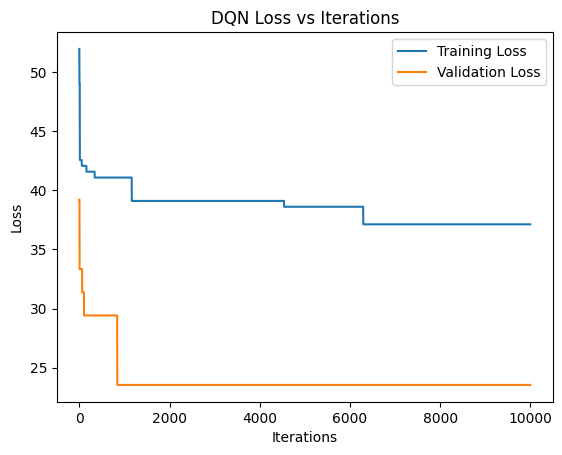

In [202]:
# plot the accuracy vs iterations
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('DQN Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [197]:
action = agent.predict(X_test[0])
print(action)

1/1 [==============================] - 0s 486ms/step
1


In [198]:
weights = agent.model.get_weights()
print(weights)

[array([[[[ 7.7582926e-02, -3.7366819e-02, -6.3526228e-02, ...,
          -5.9909578e-02, -5.2728739e-02,  4.9345747e-02],
         [ 1.5608802e-02,  5.8837146e-02,  3.2717951e-02, ...,
           7.5813398e-02,  6.2423095e-02,  6.8615854e-02],
         [-1.7272480e-02, -5.3389218e-02, -6.9670424e-02, ...,
           4.6454355e-02, -6.7180939e-02, -2.5119487e-02]],

        [[ 4.0840335e-02, -5.9374109e-02,  5.4463729e-02, ...,
           4.2234525e-02,  2.3579165e-02,  4.6019197e-02],
         [ 5.0523654e-02,  3.0598052e-02, -8.0722816e-02, ...,
           8.1962541e-02,  4.2795286e-02,  2.5495633e-02],
         [-6.2830999e-02, -2.8473634e-02,  5.3783894e-02, ...,
          -7.6341107e-02,  5.5670202e-02,  6.6939920e-02]],

        [[-4.5058627e-02,  4.8465356e-03, -1.6564779e-02, ...,
           6.8296120e-03,  3.2032929e-02, -3.9632913e-02],
         [ 6.8866670e-02,  3.6770247e-02,  4.0696427e-02, ...,
          -1.8648207e-03, -3.6043905e-02, -6.6878796e-02],
         [-8.015919